In [1]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [2]:
# Jupyter viewing options
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', 500)

### Import and clean data

In [3]:
df = pd.read_csv("W207_Group_Project/ob_data_w207_filtered.csv")

In [ ]:
print("Column count:", len(df.columns))
print("Column names:", df.columns)
print()
print("clean label:",df.exercise_clean.unique())
print("clean label2:", df.exercise_clean2.unique())
print("dataset size:", len(df))

In [4]:
# simplify the exercise labels to just 3 classes

def ex_name(exercise):
    
    if "bench" in exercise.lower():
        return "bench"
    elif "dead" in exercise.lower():
        return "dead lift"
    elif "squat" in exercise.lower():
        return "squat"
    else:
        return exercise.lower()
    
df['exercise_3classes'] = df['exercise_clean'].apply(ex_name)

df['rpe'] = pd.to_numeric(df['rpe'], errors='coerce')  # imports as a string, coerce to numeric

### Define Features and Training Data Sets

In [5]:
# subset of columns that are likely to be interesting / predictive
features = df[['rpe', 'RepCount', 'AvgVel', 'ROM', 'PeakVel', 'PeakVelLoc', 'RepDur', 'TimeBWReps', 'TimeRepComp', 'TimeRepWait', 'PeakAccel', 'weight_lbs']]

# labels
labels = df['exercise_3classes']

In [6]:
# shuffle data and divide into train and test
train_data, test_data, train_labels, test_labels = train_test_split(features, labels, test_size=0.3, random_state=100)

In [7]:
# old way -- delete later
# train_data = features[:200000].copy()
# train_labels = labels[:200000].copy()
# test_data = features[200000:].copy()
# test_labels = labels[200000:].copy()

print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(205037, 12)
(205037,)
(87873, 12)
(87873,)


### Model Formation

In [8]:
pipeline = Pipeline(steps=[
    ('imputer', preprocessing.Imputer(strategy='mean')),
    ('scale', preprocessing.StandardScaler()),
    ('PCA', PCA()),
    ('randomforest', RandomForestClassifier())])

parameters = {
    "PCA__n_components":[2,4,6],
    "randomforest__n_estimators":[2,4,6,8],
}

# scoring method - F1
f1 = metrics.make_scorer(metrics.f1_score, average="micro")

In [10]:
grid_search = GridSearchCV(pipeline, parameters, scoring=f1)
grid_search.fit(train_data, train_labels)

test_predicts = grid_search.predict(test_data)
classes = grid_search.classes_

print("score:", grid_search.score(test_data, test_labels))


score: 0.9010276194052781


### Model Evaluation

In [11]:
# classification report

cr = metrics.classification_report(test_labels, test_predicts)

print(cr)

             precision    recall  f1-score   support

      bench       0.93      0.97      0.95     39004
  dead lift       0.78      0.74      0.76     12999
      squat       0.91      0.89      0.90     35870

avg / total       0.90      0.90      0.90     87873



Confusion matrix, without normalization
[[37763   453   788]
 [  911  9668  2420]
 [ 1877  2248 31745]]
Normalized confusion matrix
[[0.97 0.01 0.02]
 [0.07 0.74 0.19]
 [0.05 0.06 0.89]]


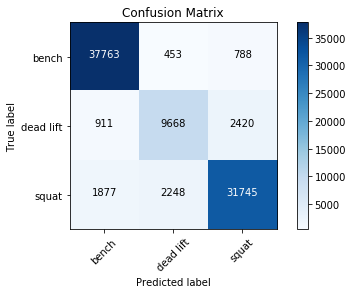

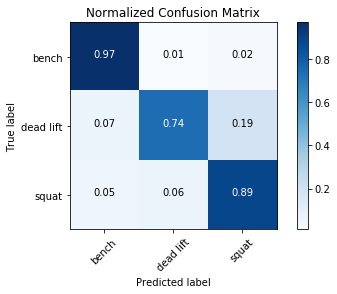

In [12]:
# confusion matrix

cm = metrics.confusion_matrix(test_labels, test_predicts)
np.set_printoptions(precision=2)


# borrowed from scikit learn tutorial
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


plt.figure()
plot_confusion_matrix(cm, classes, title="Confusion Matrix")

plt.figure()
plot_confusion_matrix(cm, classes, normalize=True, title='Normalized Confusion Matrix')
    
plt.show()